In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter("ignore")

from pathlib import Path
import geopandas as gpd
import numpy as np
import pandas as pd
from powergenome.generators import GeneratorClusters, add_genx_model_tags
from powergenome.GenX import reduce_time_domain
from powergenome.load_profiles import make_final_load_curves
from powergenome.params import DATA_PATHS
from powergenome.util import (
    build_scenario_settings,
    init_pudl_connection,
    load_settings,
)
from powergenome.external_data import (
    make_demand_response_profiles,
    make_generator_variability,
)

from powergenome.load_profiles import (
    make_load_curves, 
    add_load_growth, 
    make_final_load_curves, 
    make_distributed_gen_profiles,
)
from powergenome.external_data import make_demand_response_profiles
from powergenome.generators import GeneratorClusters
from powergenome.util import (
    build_scenario_settings,
    init_pudl_connection,
    load_settings,
    reverse_dict_of_lists,
    remove_feb_29
)

from powergenome.load_profiles import make_final_load_curves
from powergenome.generators import GeneratorClusters
from powergenome.util import (
    build_scenario_settings,
    init_pudl_connection,
    load_settings,
    reverse_dict_of_lists
)

from powergenome.GenX import reduce_time_domain, add_misc_gen_values
from powergenome.external_data import make_generator_variability

from powergenome.generators import load_ipm_shapefile
from powergenome.GenX import (
    network_line_loss,
    network_max_reinforcement,
    network_reinforcement_cost,
)
from powergenome.transmission import (
    agg_transmission_constraints,
    transmission_line_distance,
)
from powergenome.util import init_pudl_connection, load_settings

pd.options.display.max_columns = 200

In [2]:
import pandas as pd
import numpy as np
import os
import sqlite3
import shutil
import datetime
import matplotlib.pyplot as plt

In [3]:
example_system = 0
if example_system ==1:
    run_folder = "example_system" 
    settings_file = "test_settings.yml" 
    scenario = "p1"
else:
    run_folder = "US_National"
    settings_file = "US_N_settings_8.yml"
    scenario = "p6"

In [4]:
# Create New SQL File
emptydB = '/Users/aranyavenkatesh/Documents/EnergyOutlook/temoa/data_files/US_National_region.sqlite'
#outfilename_w_ext = outFilename + '.sqlite'
if example_system==1:
    outputdB = '/Users/aranyavenkatesh/Documents/EnergyOutlook/temoa/data_files/CA_twozone_test.sqlite'
else:
    outputdB = '/Users/aranyavenkatesh/Documents/EnergyOutlook/temoa/data_files/US_National_Elec_PG_8.sqlite'


In [5]:
pudl_engine, pudl_out = init_pudl_connection()
cwd = Path.cwd()

settings_path = (
    cwd / run_folder / settings_file
)
settings = load_settings(settings_path)
settings["input_folder"] = settings_path.parent / settings["input_folder"]
scenario_definitions = pd.read_csv(
    settings["input_folder"] / settings["scenario_definitions_fn"]
)
scenario_settings = build_scenario_settings(settings, scenario_definitions)

In [6]:
all_periods = list(scenario_settings.keys())
start_year = all_periods[0]
run_new = 0
file_prefix = str(settings_path).replace('.yml','_')

In [7]:
if run_new==1:
    new_gen = pd.DataFrame()
    for year in all_periods[1:]: #new gen for start year is included in all_gen
        gc = GeneratorClusters(pudl_engine, pudl_out, scenario_settings[year][scenario])
        new_gen_year = gc.create_new_generators()
        new_gen_year.loc[:,'operating_year'] = year
        new_gen = pd.concat([new_gen, new_gen_year]) #create new generators for periods beyond the first

    load_curves = make_final_load_curves(pudl_engine, scenario_settings[start_year][scenario])

    gc = GeneratorClusters(pudl_engine, pudl_out, scenario_settings[start_year][scenario])
    all_gens = gc.create_all_generators() #create existing and new generators for the first time period
    
    #add misc_values from misc_gen_inputs_fn file in extra_inputs folder
    all_gens = add_misc_gen_values(all_gens,settings)
    new_gen = add_misc_gen_values(new_gen,settings)

    gen_variability = make_generator_variability(all_gens)

    (
        reduced_resource_profile,
        reduced_load_profile,
        long_duration_storage,
    ) = reduce_time_domain(gen_variability, load_curves, scenario_settings[start_year][scenario])
    
    if len(settings['region_aggregations'])>1:
        transmission = agg_transmission_constraints(pudl_engine=pudl_engine, settings=settings)
        model_regions_gdf = load_ipm_shapefile(settings)
        transmission = transmission_line_distance(
            trans_constraints_df=transmission,
            ipm_shapefile=model_regions_gdf,
            settings=settings,
        )
        transmission = network_line_loss(transmission=transmission, settings=settings)
        transmission = network_reinforcement_cost(transmission=transmission, settings=settings)
        transmission = network_max_reinforcement(transmission=transmission, settings=settings)
        transmission.to_csv(file_prefix + 'transmission.csv', index=False)

    reduced_load_profile.to_csv(file_prefix + 'reduced_load_profile.csv', index=False)
    reduced_resource_profile.to_csv(file_prefix + 'reduced_resource_profile.csv', index=False)
    all_gens.to_csv(file_prefix + 'all_gens.csv', index=False)
    new_gen.to_csv(file_prefix + 'new_gen.csv', index=False)


In [8]:
if run_new!=1:
    reduced_load_profile = pd.read_csv(file_prefix + 'reduced_load_profile.csv')
    reduced_resource_profile = pd.read_csv(file_prefix + 'reduced_resource_profile.csv')
    all_gens = pd.read_csv(file_prefix + 'all_gens.csv')
    new_gen = pd.read_csv(file_prefix + 'new_gen.csv')
    if len(settings['region_aggregations'])>1:
        transmission = pd.read_csv(file_prefix + 'transmission.csv')

In [9]:
#create unique technology with resource, region and cluster name
all_gens.loc[:, 'tech'] =  all_gens.loc[:, 'Resource'] + '-' + all_gens.loc[:,'region'] + '-' +all_gens.loc[:,'cluster'].map(int).map(str)
#concat start year gens with remaining new gens
all_gens_multi_year = pd.concat([all_gens, new_gen])
all_gens_multi_year = all_gens_multi_year[all_gens.columns]
all_gens_multi_year.loc[np.isnan(all_gens_multi_year.operating_year),'operating_year'] = all_periods[0]
all_gens_multi_year.loc[all_gens_multi_year.operating_year==0,'operating_year'] = all_periods[0]

In [10]:
def return_region(df_tech):
    return [x[1] for x in df_tech.str.split('-')]

In [11]:
def return_tech(df_tech):
    return [x[0]+'_'+x[2] for x in df_tech.str.split('-')]

In [12]:
#run query
def run_query(query, outputdB):
    conn = sqlite3.connect(outputdB)
    c = conn.cursor()
    c.execute(query)
    conn.commit()
    conn.close()

In [13]:
def write_sql(df_table, sqlite_table, outputdB):
#code snippets from https://github.com/EnergyModels/temoatools/tree/master/temoatools

    df_table = pd.DataFrame(df_table)
    
    # Set-up sqlite connection
    conn = sqlite3.connect(outputdB)
    c = conn.cursor()

    #----------
    # sqlite file prep
    #----------

    # Create SQL command based on number of entries
    command = 'INSERT INTO ' + sqlite_table + ' VALUES (?'
    for i in range(len(df_table.columns)-1):
        command = command + ',?'
    command = command + ')'

    # Execute SQL command
    try:
        c.executemany(command,np.array(df_table))
    except:
        print(command)
        print(np.array(df_table))
        c.executemany(command, np.array(df_table))

    #----------
    # Save(commit) the changes and close sqlite file
    #----------
    conn.commit()
    conn.close()

In [14]:
rewrite=1
if rewrite==1:
    # Delete old *.sqlite file (if it already exists) and copy/rename copy of temoa_schema.sqlite
    if os.path.isfile(outputdB):
        os.remove(outputdB)
    shutil.copyfile(emptydB, outputdB)
    ##remove data from tables
    
    #remove entire table
    for table in ['CapacityToActivity','SegFrac', 'DemandSpecificDistribution', 'LifetimeProcess', 
                  'MinCapacity', 'StorageDuration','MinGenGroupWeight','MinGenGroupTarget',
                  'time_of_day', 'time_season', 'time_periods', 'tech_nonrenewable', 'tech_renewable',
                  'Output_CapacityByPeriodAndTech','Output_V_Capacity','Output_VFlow_In', 'Output_VFlow_Out',
                  'Output_Objective', 'Output_Emissions', 'Output_Curtailment', 'Output_Costs',
                  'EmissionLimit'
                  ]:
        query = """DELETE FROM """ + table
        run_query(query, outputdB)
        
    #delete IMPELC
    query = """DELETE FROM Efficiency WHERE tech='IMPELC'"""
    run_query(query, outputdB)
    
    #delete distributed generation (from solar) from Efficiency table in original database
    query = """DELETE FROM Efficiency WHERE input_comm='ELCDIST_R'"""
    run_query(query, outputdB)
    
    #modify efficiency for processes that meet demands that can only be met by processes of vintage 2017
    for table in ['Efficiency','EmissionActivity']:
        query = """UPDATE """ + table + """ SET vintage=2020
        WHERE vintage=2017
        AND input_comm || tech || output_comm NOT IN 
        (
            SELECT DISTINCT
            input_comm || tech || output_comm
            FROM """ + table + """ WHERE vintage = 2020
        )"""
        run_query(query, outputdB)
    #modify cost tables to account for these processes
    for table in ['CostFixed','CostVariable']:
        query= """UPDATE """ + table + """ SET vintage=2020
            WHERE 
              vintage = 2017 
              AND
              tech NOT IN 
            (SELECT DISTINCT
              tech
            FROM """ + table + """ WHERE vintage = 2020)"""
        run_query(query, outputdB)
    
    #delete efficiencies from 2017 vintages
    for table in ['Efficiency','EmissionActivity']:
        query = """DELETE FROM """ + table + """ WHERE vintage=2017"""
        run_query(query, outputdB)
    
    #remove demands, techinput split before 2020
    for table in ['Demand','TechInputSplit', 'MinActivity', 'MaxActivity','CostFixed','CostVariable']:
        query = """DELETE FROM """ + table +""" where periods < 2020"""
        run_query(query, outputdB)
    for table in ['CostFixed','CostVariable']:
        query = """DELETE FROM """ + table +""" where vintage=2017"""
        run_query(query, outputdB)
    for table in ['CostInvest', 'DiscountRate']:
        query = """DELETE FROM """ + table + """ where vintage < 2020"""
        run_query(query, outputdB)
    
    #remove data from specified table relating to elec techs
    for table in ['CostInvest','CostVariable','CostFixed','ExistingCapacity', 'MaxActivity',
                 'DiscountRate','LifetimeLoanTech','LifetimeTech','CapacityCredit','CapacityFactorTech',
                 'MaxCapacity', 'tech_reserve', 'tech_groups', 'EmissionActivity','Efficiency']:
        query = """DELETE FROM """ + table +""" WHERE REPLACE(tech, ' ','') in (SELECT tech FROM technologies WHERE (flag='p' OR flag='pb' or flag='ps') AND sector='PowerPlants')"""
        run_query(query, outputdB)
    table = 'tech_curtailment'
    query = """DELETE FROM """ + table +""" WHERE REPLACE(tech, ' ','') in (SELECT tech FROM technologies WHERE (flag='p' OR flag='pb' or flag='ps') AND sector='PowerPlants')"""
    run_query(query, outputdB)   
    query = """DELETE FROM technologies WHERE (flag='p' OR flag='pb' OR flag='ps') AND sector='PowerPlants'"""
    run_query(query, outputdB)
    
    
    
    string = 'ECA, URN_R, ECG, COALIGCC_N, COALSTM_R, COALIGCC_CCS_N'
    string+= ', ' + 'COALSTM_R_L, COALIGCC_N_CC, COALSTM_R_B, COALSTM_R_S' 
    string+= ', ' + 'COAS_R, COAB_R, COALIGCC_N_B, COAL_R, COALIGCC_N_S, COALIGCC_N_L'
    string+= ', ' + 'COALM_IGCC_N, COAS_R_SCR_PT, COASL_IGCC_N, COASM_IGCC_N, COAL_R_SCR_PT, COABL_IGCC_N, COABM_IGCC_N, COALH_IGCC_N, COABH_IGCC_N, COAB_R_SCR_PT'
    string+= ', ' + 'COAS_R_LNB_PT, COAL_R_LNB_PT, COAL_R_LNB, COAB_R_LNB_PT, COAS_R_LNB, COAB_R_LNB'
    string+= ', ' + 'COAB_R_CC, COAS_R_CC, COAL_R_CC'
    string+= ', ' + 'COALM_R, COALH_R, COABH_R, COABL_R, COASL_R, COABM_R, COASM_R'
    string+= ', ' + 'ELCDIST_R'
    string = "('" + ("','").join([x.strip() for x in string.split(',')]) + "')"
    query = """DELETE FROM commodities where REPLACE(comm_name,' ','') in """ + string 
    run_query(query, outputdB)
    query = """DELETE FROM Efficiency where REPLACE(output_comm,' ','') in """ + string 
    run_query(query, outputdB)
    query = """DELETE FROM EmissionActivity where REPLACE(output_comm,' ','') in """ + string 
    run_query(query, outputdB)
    
    string = 'E_LNBSCR_COAS_N, E_PTNOXLNB_COAB, E_PTSO2_COASM, E_BLND_SUBML_COALIGCC_N, E_PTCO2_COAB, E_SNCR_COAL_N, E_FGD_COABM_R, E_PTNOXSCR_COAS, E_BLND_SUBBIT_COALSTM_R, E_FGD_COASL_N, E_PTNOXSCR_COAL, E_BLND_LIGHM_COALIGCC_N, E_LNBSCR_COAL_N, E_SNCR_COAS_N, E_LNB_COAS_N, E_FGD_COABM_N, E_FGD_COABH_R, E_LNB_COAB_R, E_FGD_COABH_N, E_SCR_COAL_N, E_LNB_COAB_N, E_PTCO2_COAL, E_FGD_COASL_R, E_FGD_COASM_R, E_LNBSNCR_COAL_N, E_SCR_COAS_N, E_LNBSCR_COAB_N, E_PTNOXSCR_COAB, E_PTSO2_COABM, E_FGD_COABL_R, E_PTSO2_COALM, E_SCR_COAS_R, E_BLND_BIT_COALSTM_R, E_LNB_COAL_R, E_LNB_COAL_N, E_PTNOXLNB_COAS, E_SNCR_COAB_R, E_PTNOXLNB_COAL, E_PTSO2_COABH, E_LNBSNCR_COAB_R, E_SNCR_COAS_R, E_PTCO2_COAS, E_SCR_COAB_N, E_LNBSCR_COAB_R, E_FGD_COALH_N, E_LNBSNCR_COAB_N, E_LNB_COAS_R, E_FGD_COALH_R, IMPECA, E_CCR_COAB, E_BLND_LIG_COALSTM_R, E_FGD_COALM_N, E_FGD_COABL_N, E_CCR_COAS, E_LNBSNCR_COAS_R, E_BLND_BITHML_COALIGCC_N, E_BLND_BITSUBLIG_COALSTM_R, E_SCR_COAB_R, IMPECG, E_LNBSCR_COAS_R, E_PTSO2_COASL, E_PTSO2_COABL, E_CCR_COAL, E_PTSO2_COALH, E_FGD_COASM_N, E_CCR_COALIGCC_N, E_SNCR_COAB_N, E_FGD_COALM_R, E_LNBSNCR_COAS_N, E_BLND_BITSUBLIG_COALIGCC_N'
    string+= ', ' + 'IMPELC'
    string = "('" + ("','").join([x.strip() for x in string.split(',')]) + "')"
    for table in ['technologies', 'MaxActivity','ExistingCapacity','LifetimeTech','CostFixed','CostVariable','CostInvest']:
        query = """DELETE FROM """ + table + """ WHERE REPLACE(tech,' ','') in """ + string 
        run_query(query, outputdB)
        
    
    #delete techs that are dead on arrival
    for table in ['EmissionActivity','Efficiency', 'ExistingCapacity']:
        query = """DELETE FROM """ + table + """ WHERE """ + table + """.tech || vintage 
        IN
        (
          SELECT 
              ExistingCapacity.tech || vintage AS tech_plus_vintage 
           FROM 
              ExistingCapacity LEFT JOIN LifetimeTech 
              ON ExistingCapacity.tech=LifetimeTech.tech 
           WHERE vintage+life <=2020
         )
        """
        run_query(query, outputdB)

In [15]:
def create_table(outputdB, table_name, primary_key, foreign_key, key_val, references=0):
    create_table_sql = """CREATE TABLE IF NOT EXISTS """ + table_name + """ ( 
                         """ + primary_key + """ text primary key"""
    
    for key in key_val.keys():
        create_table_sql += """, """ + key + """ """ + key_val[key] 
                         
    if references!=0:
        for key in references.keys():
            create_table_sql += """, FOREIGN KEY(""" + foreign_key + """) REFERENCES """ + key + """(""" + references[key] + """)"""
            
        create_table_sql += """);"""
    else:
        create_table_sql += """);"""
    
    conn = sqlite3.connect(outputdB)
    c = conn.cursor()
    c.execute(create_table_sql)
    conn.commit()    

In [16]:
def create_table_mult_pkey(outputdB, table_name, primary_key, foreign_key, key_val, references=0):
    create_table_sql = """CREATE TABLE IF NOT EXISTS """ + table_name + """("""
    
    for key in key_val.keys():
        create_table_sql +=  key + """ """ + key_val[key] + """, """
                         
    if references!=0:
        for key in references.keys():
            create_table_sql += """ FOREIGN KEY(""" + foreign_key + """) REFERENCES """ + key + """(""" + references[key] + """)"""
            
        #create_table_sql += ""","""
    #else:
        create_table_sql += ""","""
        
    create_table_sql+= """ PRIMARY KEY """ + primary_key  + """);"""
    
    conn = sqlite3.connect(outputdB)
    c = conn.cursor()
    c.execute(create_table_sql)
    conn.commit()

In [17]:
#def prep_tables(period, folder_name, gen_data, capfac_variability_data):
    #PREPARE DATABASE TABLES
    
df_gen= all_gens_multi_year
df_gen.rename(columns={'region':'regions'}, inplace=True)

df_gen.loc[:,'regions'] = df_gen.loc[:,'regions'].str.replace('US_N','US')
df_gen.loc[:, 'tech'] =  df_gen.loc[:, 'Resource'] + '-' + df_gen.loc[:,'regions'] + '-' +df_gen.loc[:,'cluster'].map(int).map(str)

#remove battery, pumped storage and ev_shifting (after column names have been assigned to capfac dataframe)
df_gen = df_gen.loc[~df_gen.loc[:,'tech'].str.contains('ev_'),:]
df_gen = df_gen.loc[~df_gen.loc[:,'tech'].str.contains('battery'),:]
df_gen = df_gen.loc[~df_gen.loc[:,'tech'].str.contains('pumped'),:]
#rename operating_year as vintage
df_gen.rename(columns={'operating_year':'vintage'},inplace=True)
df_gen= df_gen.astype({'vintage':int})
df_gen.loc[:,'renewable_nonstor'] = df_gen.loc[:,'RPS'] | df_gen.loc[:,'HYDRO'] 

#capacityfactortech
df_capfac= reduced_resource_profile.reset_index(drop=True)
df_capfac.columns = all_gens.loc[:,'tech'] #rename columns to match df_gen technologies
#remove battery and ev_shifting
df_capfac.drop(columns=df_capfac.columns[df_capfac.columns.str.contains('ev')], inplace=True)
df_capfac.drop(columns=df_capfac.columns[df_capfac.columns.str.contains('battery')], inplace=True)
df_capfac.drop(columns=df_capfac.columns[df_capfac.columns.str.contains('pumped')], inplace=True)

intra_annual_periods = len(df_capfac)
days = intra_annual_periods/24
iter_val = 0
for day in np.arange(days)+1:
    df_capfac.loc[iter_val:iter_val+23,'season_name'] = 'S' + str(int(day))
    df_capfac.loc[iter_val:iter_val+23,'time_of_day_name'] = ['H' + str(int(x)) for x in np.arange(1,25)]
    iter_val+=24
df_capfac = df_capfac.melt(id_vars=['season_name','time_of_day_name'])
df_capfac = df_capfac.rename(columns={'variable':'tech', 'value':'cf_tech'})
df_capfac.loc[:,'cf_tech_notes'] = 'from Power Genome: ' + scenario
df_capfac.insert(0,'regions',return_region(df_capfac.loc[:,'tech']))
df_capfac.loc[:,'regions'] = df_capfac.loc[:,'regions'].str.replace('US_N','US')
df_capfac.loc[:,'tech'] = return_tech(df_capfac.loc[:,'tech'])
#remove techs that have constant capacity factor
df_sum = df_capfac.groupby(by=['regions','tech']).sum().reset_index()
df_fixed_capfac = df_sum[df_sum.cf_tech==intra_annual_periods]
df_fixed_capfac.rename(columns={'cf_tech': 'cf_tech_max'}, inplace=True)
df_capfac = df_capfac.merge(df_fixed_capfac, on = ['regions','tech'], how='outer')
df_capfac = df_capfac[df_capfac.cf_tech_max!=intra_annual_periods]
df_capfac = df_capfac.drop('cf_tech_max',axis=1)

#segfrac for a chronological model has equal weights for all time periods, with a sum of 1
df_segfrac = df_capfac.loc[:,['season_name','time_of_day_name']].copy()
df_segfrac.drop_duplicates(inplace=True) 
df_segfrac.loc[:,'segfrac'] = 1/len(df_segfrac)
df_segfrac.loc[:,'segfrac_notes'] = 'from Power Genome: ' + scenario

#identify renewables that qualify for RPS and hydro, but not storage 
df_gen.loc[:,'renewable_nonstor'] = df_gen.loc[:,'RPS'] | df_gen.loc[:,'HYDRO'] 

#update lifetime as difference between retirement year and operating year
df_gen.loc[:,'lifetime_diff'] = df_gen.loc[:,'retirement_year'] - df_gen.loc[:,'vintage']
df_gen.loc[:,'lifetime_diff'].fillna(0, inplace=True)

df_gen.loc[:,'lifetime'].fillna(0, inplace=True)
df_gen.loc[:,'lifetime'] = df_gen.loc[:, ['lifetime', 'lifetime_diff']].max(axis=1)

#capacitytoactivity for a chronological model, to normalize to annual time periods, assuming min value is hours
df_c2a = df_gen.loc[:,['tech']].drop_duplicates()
#remove battery and ev_shifting
df_c2a = df_c2a.loc[~df_c2a.loc[:,'tech'].str.contains('ev_'),:]
df_c2a = df_c2a.loc[~df_c2a.loc[:,'tech'].str.contains('battery'),:]
df_c2a = df_c2a.loc[~df_c2a.loc[:,'tech'].str.contains('pumped'),:]

df_c2a.loc[:,'c2a'] = 31.536 #8760/(days*24)
df_c2a.loc[:,'c2a_notes'] = 'from Power Genome: ' + scenario
df_c2a.insert(0,'regions',return_region(df_c2a.loc[:,'tech']))
df_c2a.loc[:,'regions'] = df_c2a.loc[:,'regions'].str.replace('US_N','US')
df_c2a.loc[:,'tech'] = return_tech(df_c2a.loc[:,'tech'])

#investment, fixed and variable costs
df_costs = df_gen.loc[:,['tech', 'capex', 'Fixed_OM_cost_per_MWyr', 'Var_OM_cost_per_MWh', 'vintage']].copy()
df_costs.loc[:,'cost_invest'] = df_costs.loc[:, 'capex']/(10**3) #$/MW to #$M/GW
df_costs.loc[:,'cost_fixed'] = df_costs.loc[:, 'Fixed_OM_cost_per_MWyr']*(10**3)/(10**6) #$/MWyr to #$M/GW-yr
df_costs.loc[:,'cost_variable'] = df_costs.loc[:, 'Var_OM_cost_per_MWh']*(277777.78)/(10**6) #$/MWh to #$M/PJ
df_costs.loc[:,'cost_invest_units'] = '$M/GW'
df_costs.loc[:,'cost_invest_notes'] = 'from Power Genome: ' + scenario
df_costs.loc[:,'cost_fixed_units'] = '$M/GWyr'
df_costs.loc[:,'cost_fixed_notes'] = 'from Power Genome: ' + scenario
df_costs.loc[:,'cost_variable_units'] = '$M/PJ'
df_costs.loc[:,'cost_variable_notes'] = 'from Power Genome: ' + scenario
df_costs.insert(0,'regions',return_region(df_costs.loc[:,'tech']))
df_costs.loc[:,'tech'] = return_tech(df_costs.loc[:,'tech'])

df_cost_invest = df_costs.loc[:,['regions','tech','vintage','cost_invest','cost_invest_units','cost_invest_notes']].copy()
df_cost_invest = df_cost_invest.loc[df_cost_invest.cost_invest>0]

df_costv = df_costs.loc[:,['regions','tech','vintage','cost_variable','cost_variable_units','cost_variable_notes']].drop_duplicates()
df_cost_variable = pd.DataFrame(np.repeat(df_costv.values, len(all_periods), axis=0), columns= df_costv.columns)
df_cost_variable.insert(1,'periods',int((len(df_cost_variable)/len(all_periods)))*all_periods)
df_cost_variable = df_cost_variable[df_cost_variable.vintage<=df_cost_variable.periods]

df_costf = df_costs.loc[:,['regions','tech','vintage','cost_fixed','cost_fixed_units','cost_fixed_notes']]
df_cost_fixed = pd.DataFrame(np.repeat(df_costf.values, len(all_periods), axis=0), columns= df_costf.columns)
df_cost_fixed.insert(1,'periods',int((len(df_cost_fixed)/len(all_periods)))*all_periods)
df_cost_fixed = df_cost_fixed[df_cost_fixed.vintage<=df_cost_fixed.periods]

#efficiency
df_efficiency = df_gen.loc[:,['Resource','tech', 'Heat_rate_MMBTU_per_MWh','renewable_nonstor', 'vintage']].copy()
df_efficiency.rename(columns={'Resource':'input_comm'}, inplace=True)
#convert technologies with no heat rate to 100% efficiency, by setting the heat rate to 3412.0/1000 MMBTU/MWh
df_efficiency.loc[(df_efficiency.loc[:,'Heat_rate_MMBTU_per_MWh']==0),'Heat_rate_MMBTU_per_MWh'] = 3412.0/1000
df_efficiency.loc[:, 'output_comm'] = df_efficiency.loc[:,'renewable_nonstor'].apply(lambda x: 'ELCP_Renewables' if x ==1 else 'ELCP')
df_efficiency.loc[:,'efficiency'] = 3412.0/(df_efficiency.loc[:,'Heat_rate_MMBTU_per_MWh']*1000)
df_efficiency.loc[:,'efficiency'].fillna(1.0, inplace=True)
df_efficiency.drop(columns=['Heat_rate_MMBTU_per_MWh','renewable_nonstor'], inplace=True)
df_efficiency.loc[:,'eff_notes'] = 'from Power Genome: ' + scenario
#remove battery and ev_shifting
df_efficiency = df_efficiency.loc[~df_efficiency.loc[:,'tech'].str.contains('ev_'),:]
df_efficiency = df_efficiency.loc[~df_efficiency.loc[:,'tech'].str.contains('battery'),:]
df_efficiency.insert(0,'regions',return_region(df_efficiency.loc[:,'tech']))
df_efficiency.loc[:,'tech'] = return_tech(df_efficiency.loc[:,'tech'])

#ramp up and down fractions
df_ramp = df_gen.loc[(df_gen.loc[:,'Ramp_Up_percentage']>0) | (df_gen.loc[:,'Ramp_Dn_percentage']>0), ['regions','tech', 'Ramp_Up_percentage', 'Ramp_Dn_percentage']].copy()
df_ramp.rename(columns={'Ramp_Up_percentage': 'ramp_up', 'Ramp_Dn_percentage': 'ramp_down'}, inplace=True)
df_ramp.loc[:,'tech'] = return_tech(df_ramp.loc[:,'tech'])
df_ramp = df_ramp[(df_ramp.ramp_up<1) | (df_ramp.ramp_down<1)]


#lifetime
df_lifetime = df_gen.loc[:,['tech','lifetime']].copy()
df_lifetime.insert(0,'regions',return_region(df_lifetime.loc[:,'tech']))
df_lifetime.loc[:,'tech'] = return_tech(df_lifetime.loc[:,'tech'])

#existing capacity
df_ex_cap = df_gen.loc[:, ['tech','Existing_Cap_MW', 'vintage' ]]
df_ex_cap = df_ex_cap.loc[df_ex_cap.loc[:,'Existing_Cap_MW']>0,:]
df_ex_cap.loc[:,'exist_cap'] = df_ex_cap.loc[:,'Existing_Cap_MW']/1000 #GW
df_ex_cap.drop(columns=['Existing_Cap_MW'], inplace=True)
df_ex_cap.loc[:,'exist_cap_units'] = 'GW'
df_ex_cap.loc[:,'exist_cap_notes'] = 'from Power Genome: ' + scenario
##FIX THIS for zero value years for EV load shifting, removing this row for now
df_ex_cap = df_ex_cap.loc[df_ex_cap.loc[:,'vintage']!=0,:]
df_ex_cap.insert(0,'regions',return_region(df_ex_cap.loc[:,'tech']))
df_ex_cap.loc[:,'tech'] = return_tech(df_ex_cap.loc[:,'tech'])

#discount rate
df_wacc = df_gen.loc[(df_gen.loc[:,'waccnomtech']>0), ['tech', 'vintage', 'waccnomtech']].copy()
df_wacc.rename(columns={'waccnomtech': 'tech_rate'}, inplace=True)
df_wacc.loc[:,'tech_rate_notes'] = 'from Power Genome: ' + scenario
df_wacc.insert(0,'regions',return_region(df_wacc.loc[:,'tech']))
df_wacc.loc[:,'tech'] = return_tech(df_wacc.loc[:,'tech'])

#capital recovery years
df_cap_rec_years = df_gen.loc[(df_gen.loc[:,'cap_recovery_years']>0),['tech', 'cap_recovery_years']].copy()
df_cap_rec_years.rename(columns={'cap_recovery_years': 'loan'}, inplace=True)
df_cap_rec_years.loc[:,'loan_notes'] = 'from Power Genome: ' + scenario
df_cap_rec_years.insert(0,'regions',return_region(df_cap_rec_years.loc[:,'tech']))
df_cap_rec_years.loc[:,'tech'] = return_tech(df_cap_rec_years.loc[:,'tech'])

#lifetime
df_lifetime = df_gen.loc[(df_gen.loc[:,'lifetime']>0),['tech', 'lifetime']].copy()
df_lifetime.rename(columns={'lifetime': 'life'}, inplace=True)
df_lifetime.loc[:,'life_notes'] = 'from Power Genome: ' + scenario
df_lifetime.insert(0,'regions',return_region(df_lifetime.loc[:,'tech']))
df_lifetime.loc[:,'tech'] = return_tech(df_lifetime.loc[:,'tech'])

#capacity credit
df_ccredit = df_gen.loc[df_gen.loc[:,'CapRes']>0, ['tech', 'CapRes']].copy()
df_ccredit  = pd.DataFrame(np.repeat(df_ccredit.values, len(all_periods), axis=0), columns= df_ccredit.columns)
df_ccredit.insert(0,'periods',int((len(df_ccredit)/len(all_periods)))*all_periods)
df_ccredit.rename(columns={'CapRes': 'cf_tech'}, inplace=True)
df_ccredit.loc[:,'cf_tech_notes'] = 'from Power Genome: ' + scenario
df_ccredit.insert(0,'regions',return_region(df_ccredit.loc[:,'tech']))
df_ccredit.loc[:,'tech'] = return_tech(df_ccredit.loc[:,'tech'])

#max capacity, for renewables, primarily
df_maxcap = df_gen.loc[(df_gen.loc[:,'Max_Cap_MW']>0),['tech','Max_Cap_MW','vintage']].copy()
df_maxcap.rename(columns={'Max_Cap_MW':'maxcap', 'vintage':'periods'}, inplace=True)
df_maxcap.loc[:,'maxcap'] = df_maxcap.loc[:,'maxcap']/1000 #convert MW to GW
df_maxcap.loc[:,'maxcap_units'] = 'GW' #convert MW to GW
df_maxcap.loc[:,'maxcap_tech_notes'] = 'from Power Genome: ' + scenario
df_maxcap.insert(0,'regions',return_region(df_maxcap.loc[:,'tech']))
df_maxcap.loc[:,'tech'] = return_tech(df_maxcap.loc[:,'tech'])

#load, estimating demand specific distribution, same distribution for all demands
df_load_i = reduced_load_profile
ind = list(reduced_load_profile.columns).index('Time_index')
df_load_i = reduced_load_profile[reduced_load_profile.columns[ind+1:]]
iter_val = 0
for day in np.arange(days)+1:
    df_load_i.loc[iter_val:iter_val+23,'season_name'] = 'S' + str(int(day))
    df_load_i.loc[iter_val:iter_val+23,'time_of_day_name'] = ['H' + str(int(x)) for x in np.arange(1,25)]
    iter_val+=24
df_load_i = df_load_i.melt(id_vars=['season_name','time_of_day_name'])
df_load_i = df_load_i.rename(columns={'variable':'regions', 'value':'dds_vals'})
df_load_i.loc[:, 'regions'] = df_load_i.loc[:, 'regions'].str.replace('US_N','US')

df_load = pd.DataFrame()
for demn in ['RSC', 'RSH','RLT','ROELC','RWH','CLT','COELC','COEELC','CSC','CSH','CWH']:
    for region in df_load_i.regions.unique():
        df_load_i.loc[(df_load_i.regions==region),'demand_name'] = demn
        df_load_i.loc[(df_load_i.regions==region),'dds'] = df_load_i.loc[(df_load_i.regions==region),'dds_vals']/df_load_i.loc[(df_load_i.regions==region),'dds_vals'].sum()
        df_load = pd.concat([df_load, df_load_i.loc[(df_load_i.regions==region),['regions','season_name','time_of_day_name','demand_name','dds']]])
df_load.loc[:,'dds_notes'] = 'from Power Genome: ' + scenario
df_load.loc[:,'regions'] = df_load.loc[:,'regions'].str.replace('z1','US')

if len(settings['region_aggregations'])>1:

    #transmission efficiency
    df_trans_efficiency = pd.DataFrame()
    df_trans_efficiency.loc[:,'regions']  = transmission.loc[:,'Transmission Path Name'].str.replace('_to_','-')
    df_trans_efficiency.loc[:,'input_comm'] = 'ELC'
    df_trans_efficiency.loc[:,'tech'] = 'E_TRANS'
    df_trans_efficiency.loc[:,'vintage'] = all_periods[0]
    df_trans_efficiency.loc[:,'output_comm'] = 'ELC'
    df_trans_efficiency.loc[:,'efficiency'] = 1 - transmission.loc[:,'Line_Loss_Percentage']
    df_trans_efficiency.loc[:,'eff_notes'] = 'from Power Genome: ' + scenario
    
    df_efficiency = pd.concat([df_efficiency, df_trans_efficiency])

    #transmission costs
    df_trans_c = pd.DataFrame()
    df_trans_c.loc[:,'regions']  = transmission.loc[:,'Transmission Path Name'].str.replace('_to_','-')
    df_trans_c.loc[:,'tech'] = 'E_TRANS'
    df_trans_c.loc[:,'vintage'] = all_periods[0]
    df_trans_c.loc[:, 'cost_fixed'] = transmission.loc[:, 'Line_Reinforcement_Cost_per_MW_yr']*(10**3)/(10**6) #$/MWyr to #$M/GW-yr
    df_trans_c.loc[:, 'cost_fixed_units'] = '$M/GWyr'
    df_trans_c.loc[:, 'cost_fixed_notes'] = 'from Power Genome: ' + scenario
    df_trans_costs = pd.DataFrame(np.repeat(df_trans_c.values, len(all_periods), axis=0), columns= df_trans_c.columns)
    df_trans_costs.insert(1,'periods',int((len(df_trans_costs)/len(all_periods)))*all_periods)
    df_trans_costs = df_trans_costs[df_trans_costs.vintage<=df_trans_costs.periods]
    
    df_cost_fixed = pd.concat([df_cost_fixed, df_trans_costs])

    #trans maximum capacity
    df_trans_maxcap = pd.DataFrame()

    df_trans_maxcap.loc[:,'regions']  = transmission.loc[:,'Transmission Path Name'].str.replace('_to_','-')
    df_trans_maxcap.loc[:,'maxcap'] = abs(transmission.loc[:,['Line_Max_Flow_MW', 'Line_Min_Flow_MW']]).max(axis=1).values/1000

    df_trans_maxcap.insert(1,'tech', 'E_TRANS')
    df_trans_maxcap.loc[:,'maxcap_units'] = 'GW'
    df_trans_maxcap.loc[:,'maxcap_notes'] = 'from Power Genome: ' + scenario

    df_trans_maxcap_periods = pd.DataFrame(np.repeat(df_trans_maxcap.values, len(all_periods), axis=0), columns= df_trans_maxcap.columns)
    df_trans_maxcap_periods.insert(1,'periods',int((len(df_trans_maxcap_periods)/len(all_periods)))*all_periods)
    
    df_maxcap = pd.concat([df_maxcap, df_trans_maxcap_periods])

In [18]:
#add input_comm from commodities list
df_efficiency.loc[df_efficiency.loc[:,'input_comm'].str.contains('bio'),'input_comm'] = 'AGR'
df_efficiency.loc[df_efficiency.loc[:,'input_comm'].str.contains('utilitypv'),'input_comm'] = 'ethos_R'
df_efficiency.loc[df_efficiency.loc[:,'input_comm'].str.contains('wind'),'input_comm'] = 'ethos_R'
df_efficiency.loc[df_efficiency.loc[:,'input_comm'].str.contains('nuclear'),'input_comm'] = 'URN_N'
df_efficiency.loc[df_efficiency.loc[:,'input_comm'].str.contains('natural'),'input_comm'] = 'E_NGA'
df_efficiency.loc[df_efficiency.loc[:,'input_comm'].str.contains('coal'),'input_comm'] = 'COALSTM_N'
df_efficiency.loc[df_efficiency.loc[:,'input_comm'].str.contains('hydro'),'input_comm'] = 'ethos_R'
df_efficiency.loc[df_efficiency.loc[:,'input_comm'].str.contains('solar'),'input_comm'] = 'ethos_R'
df_efficiency.loc[df_efficiency.loc[:,'input_comm'].str.contains('geo'),'input_comm'] = 'ethos_R'

In [19]:
#change existing wind and solar efficiencies to 1
df_efficiency.loc[(df_efficiency.loc[:,'tech'].str.contains('wind')) & (df_efficiency.loc[:,'vintage']<start_year), 'efficiency'] = 1
df_efficiency.loc[(df_efficiency.loc[:,'tech'].str.contains('solar')) & (df_efficiency.loc[:,'vintage']<start_year), 'efficiency'] = 1

In [20]:
#WRITE TO DATABASE

#CapacityToActivity
df_table = df_c2a.drop_duplicates()
sqlite_table = 'CapacityToActivity'
write_sql(df_table, sqlite_table, outputdB)

#SegFrac
df_table = df_segfrac.drop_duplicates()
sqlite_table = 'SegFrac'
write_sql(df_table, sqlite_table, outputdB)

#CostInvest
df_table = df_cost_invest.copy()
df_table = df_table.loc[df_table.loc[:,'cost_invest']>0,:]
sqlite_table = 'CostInvest'
write_sql(df_table, sqlite_table, outputdB)

#CostVariable
df_table = df_cost_variable.drop_duplicates()
sqlite_table = 'CostVariable'
write_sql(df_table, sqlite_table, outputdB)

#CostFixed
df_table = df_cost_fixed.drop_duplicates()
sqlite_table = 'CostFixed'
write_sql(df_table, sqlite_table, outputdB)

#Efficiency
df_table = df_efficiency.drop_duplicates()
sqlite_table = 'Efficiency'
write_sql(df_table, sqlite_table, outputdB)

#tech_curtailment
df_table = pd.DataFrame(df_efficiency.loc[['wind' in x or 'pv' in x or 'solar' in x for x in df_efficiency.loc[:,'tech']],'tech'].drop_duplicates())
df_table.insert(1,'notes','')
sqlite_table = 'tech_curtailment'
write_sql(df_table, sqlite_table, outputdB)

#tech_nonrenewable
df_table = df_efficiency.loc[df_efficiency.loc[:,'output_comm']=='ELCP','tech'].drop_duplicates()
sqlite_table = 'tech_nonrenewable'
write_sql(df_table, sqlite_table, outputdB)

#tech_renewable
df_table = df_efficiency.loc[df_efficiency.loc[:,'output_comm']=='ELCP_Renewables','tech'].drop_duplicates()
sqlite_table = 'tech_renewable'
write_sql(df_table, sqlite_table, outputdB)

#tech_production in technologies table
df_table = pd.DataFrame(df_efficiency.loc[:,'tech'].drop_duplicates())
df_table.insert(1,'flag' ,'p')
df_table.insert(2, 'sector','PowerPlants')
df_table.insert(3,'tech_desc','generates electricity, from Powergenome')
df_table.insert(4,'tech_catgory','')
sqlite_table = 'technologies'
write_sql(df_table, sqlite_table, outputdB)

#Ramping
#ramping techs
references = dict()
references['technologies'] = 'tech'
create_table(outputdB, 'tech_ramping', 'tech', 'tech', dict(),references)

df_table = df_ramp.loc[:,['tech']].drop_duplicates()
sqlite_table = 'tech_ramping'
write_sql(df_table, sqlite_table, outputdB)

#ramp up
ramp_up_pairs = dict()
ramp_up_pairs['regions'] = 'text'
ramp_up_pairs['tech'] = 'text'
ramp_up_pairs['ramp_up'] = 'real'
references = dict()
references['technologies'] = 'tech'
create_table_mult_pkey(outputdB, 'RampUp', "(regions, tech)", 'tech', ramp_up_pairs,references)

df_table = df_ramp.loc[:,['regions','tech', 'ramp_up']].drop_duplicates()
sqlite_table = 'RampUp'
write_sql(df_table, sqlite_table, outputdB)

#ramp down
ramp_up_pairs = dict()
ramp_up_pairs['regions'] = 'text'
ramp_up_pairs['tech'] = 'text'
ramp_up_pairs['ramp_up'] = 'real'
references = dict()
references['technologies'] = 'tech'
create_table_mult_pkey(outputdB, 'RampDown', "(regions, tech)", 'tech', ramp_up_pairs,references)

df_table = df_ramp.loc[:,['regions','tech', 'ramp_down']].drop_duplicates()
sqlite_table = 'RampDown'
write_sql(df_table, sqlite_table, outputdB)

#ExistingCapacity
df_table = df_ex_cap.drop_duplicates()
sqlite_table = 'ExistingCapacity'
write_sql(df_table, sqlite_table, outputdB)

#DiscountRate
df_table = df_wacc.loc[:,['regions','tech', 'vintage', 'tech_rate', 'tech_rate_notes']].drop_duplicates()
sqlite_table = 'DiscountRate'
write_sql(df_table, sqlite_table, outputdB)

#LifetimeLoanTech
df_table = df_cap_rec_years.drop_duplicates()
sqlite_table = 'LifetimeLoanTech'
write_sql(df_table, sqlite_table, outputdB)

#LifetimeTech
df_lifetime.loc[:,'life']=120 #all to 120 years for now
df_table = df_lifetime.drop_duplicates()
sqlite_table = 'LifetimeTech'
write_sql(df_table, sqlite_table, outputdB)

#CapacityCredit
df_table = df_ccredit.loc[:,['regions','periods','tech', 'cf_tech','cf_tech_notes']].drop_duplicates()
sqlite_table = 'CapacityCredit'
write_sql(df_table, sqlite_table, outputdB)

#tech_reserve
df_table = df_ccredit.loc[:,['tech','cf_tech_notes']].drop_duplicates(subset='tech')
df_table.rename(columns={'cf_tech_notes':'notes'}, inplace=True)
sqlite_table = 'tech_reserve'
write_sql(df_table, sqlite_table, outputdB)

#CapacityFactorTech
df_table = df_capfac.drop_duplicates()
sqlite_table = 'CapacityFactorTech'
write_sql(df_table, sqlite_table, outputdB)

#MaxCapacity
df_table = df_maxcap.loc[:,['regions','periods','tech', 'maxcap','maxcap_units','maxcap_tech_notes']].drop_duplicates()
sqlite_table = 'MaxCapacity'
write_sql(df_table, sqlite_table, outputdB)

#DSD
df_table = df_load.loc[:,['regions','season_name','time_of_day_name','demand_name','dds','dds_notes']]
sqlite_table = 'DemandSpecificDistribution'
write_sql(df_table, sqlite_table, outputdB)

#time_season
df_table = pd.DataFrame(df_capfac.loc[:,'season_name'].drop_duplicates())
df_table.rename(columns={'season_name':'t_season'},inplace=True)
sqlite_table = 'time_season'
write_sql(df_table, sqlite_table, outputdB)

#time_of_day
df_table = pd.DataFrame(df_capfac.loc[:,'time_of_day_name'].drop_duplicates())
df_table.rename(columns={'time_of_day_name':'t_day'},inplace=True)
sqlite_table = 'time_of_day'
write_sql(df_table, sqlite_table, outputdB)

#time_periods
df_table = pd.DataFrame(columns=['t_periods','flag'])
#df_table.loc[:,'t_periods'] = np.sort(df_costs.loc[:,'vintage'].unique().astype(int))
df_table.loc[:,'t_periods'] = np.hstack((np.arange(df_costs.loc[:,'vintage'].astype(int).min()-1,2020), 
                                         np.arange(2020,2056,5)))
df_table.loc[:,'flag'] = ['e' if x <2020  else 'f' for x in df_table.loc[:,'t_periods']]
sqlite_table = 'time_periods'
write_sql(df_table, sqlite_table, outputdB)

#add regions
if 'US' not in outputdB: 
    df_table = pd.DataFrame(columns=['regions','region_notes'])
    df_table.loc[:,'regions'] = df_gen.regions.unique()
    df_table.loc[:,'region_notes'] = ''
    sqlite_table = 'regions'
    write_sql(df_table, sqlite_table, outputdB)

In [21]:
con=sqlite3.connect(outputdB, isolation_level=None)
con.execute("VACUUM")
con.commit()
con.close()

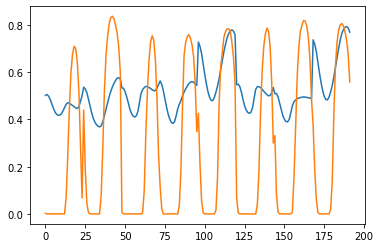

In [22]:
df_load_clt = df_load.loc[df_load.loc[:,'demand_name']=='CLT',:]
df_flow = df_load_clt.groupby(['season_name','time_of_day_name']).sum().reset_index()
#df_flow.rename(columns={'agg_tech':'tech', 't_periods':'periods'}, inplace=True)
df_flow.loc[:,'t_day'] = df_flow.loc[:,'time_of_day_name'].str.replace('H','').map(int)
df_flow.loc[:,'t_season'] = df_flow.loc[:,'season_name'].str.replace('S','').map(int)
df_flow.loc[:,'time_concat'] = df_flow.loc[:,'t_season']*100  + df_flow.loc[:,'t_day']

df_flow.sort_values(by = ['time_concat'], inplace=True)
df_flow.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()
ax.plot(df_flow.dds*100)

df_load_clt = df_capfac.loc[df_capfac.loc[:,'tech']=='utilitypv_losangeles_5',:]
df_flow = df_load_clt.groupby(['season_name','time_of_day_name']).sum().reset_index()
#df_flow.rename(columns={'agg_tech':'tech', 't_periods':'periods'}, inplace=True)
df_flow.loc[:,'t_day'] = df_flow.loc[:,'time_of_day_name'].str.replace('H','').map(int)
df_flow.loc[:,'t_season'] = df_flow.loc[:,'season_name'].str.replace('S','').map(int)
df_flow.loc[:,'time_concat'] = df_flow.loc[:,'t_season']*100  + df_flow.loc[:,'t_day']

df_flow.sort_values(by = ['time_concat'], inplace=True)
df_flow.reset_index(drop=True, inplace=True)
ax.plot(df_flow.cf_tech)

